In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
df_all = pd.read_csv('../data/string_bioplex_test.csv')
df_string = pd.read_csv('../data/string_locs2.csv')
df_bioplex = pd.read_csv('../data/bioplex_locs2.csv')
df_string = df_string[df_string.reliability1.notnull()]
df_string = df_string[df_string.reliability2.notnull()]
print(df_string.shape)

cols = ['protein1', 'protein2', 'locations']

df_all = df_all[cols]
df_string = df_string[cols]
df_bioplex = df_bioplex[cols]

omit_locs = ['Rods & Rings', 'Aggresome', 'Microtubule ends', 'Cleavage furrow']

(698531, 15)


In [3]:
def get_set(x):
    x = x[1:-1]
    x = x.replace("'", "")
    x = x.replace('"', '"').strip()
    x = x.split(',')
    x = set([i.strip() for i in x])
    return x

In [4]:
def get_loc_values(df, info_retain=1.0):
    
    # Compute a dictionary of the form {protein_id: {location: count}, ...}
    prot2loc_c = dict()
    for i in tqdm(df.index):
        p1 = df['protein1'][i]
        p2 = df['protein2'][i]
        l = get_set(df['locations'][i])

        try:
            prot2loc_c[p1]
        except:
            prot2loc_c[p1] = dict()
        try:
            prot2loc_c[p2]
        except:
            prot2loc_c[p2] = dict()

        for loc in l:
            if loc not in omit_locs:
                try:
                    prot2loc_c[p1][loc] += 1
                except:
                    prot2loc_c[p1][loc] = 1
            
                try:
                    prot2loc_c[p2][loc] += 1
                except:
                    prot2loc_c[p2][loc] = 1

    # Pick locations corresponding to a protein that hold more information than info_retain
    for i in tqdm(prot2loc_c.keys()):
        counts = prot2loc_c[i].values()
        total_c = sum(counts)
        counts = [c/total_c for c in counts]
        norm_counts = dict(zip(prot2loc_c[i].keys(), counts))
        norm_counts = {
            k: v for k, v in sorted(norm_counts.items(), key=lambda x: x[1], reverse=True)
            }

        cumsum = 0
        temp = dict()
        for key,val in norm_counts.items():
            if cumsum > info_retain:
                break
            cumsum += val
            temp[key] = val

        prot2loc_c[i] = temp
    
    # Get a dictionary that maps each location with number of proteins that might be present there.
    loc_count = dict()
    for i in tqdm(prot2loc_c.keys()):
        loc_list = prot2loc_c[i].keys()
        
        # for loc in loc_list:
        n = len(loc_list)
        try:
            loc_count[n] += 1
        except:
            loc_count[n] = 1
    
    return {k: v for k, v in sorted(loc_count.items(), key=lambda x: x[0])}

In [5]:
def plot(loc_all, loc_string, loc_bioplex, path):
    locs1 = loc_all.keys()
    values1 = loc_all.values()
    locs2 = loc_string.keys()
    values2 = loc_string.values()
    locs3 = loc_bioplex.keys()
    values3 = loc_bioplex.values()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

    axes[0].bar(locs1,values1)
    axes[0].set_title('Combined')
    axes[1].bar(locs2,values2)
    axes[1].set_title('STRING')
    axes[2].bar(locs3,values3)
    axes[2].set_title('BioPlex')

    for ax in axes.flat:
        ax.set(xlabel='Location Count', ylabel='# of Proteins')

    fig.tight_layout()
    fig.savefig(path)
    # fig.show()

100%|██████████| 12136/12136 [00:00<00:00, 1336679.01it/s]


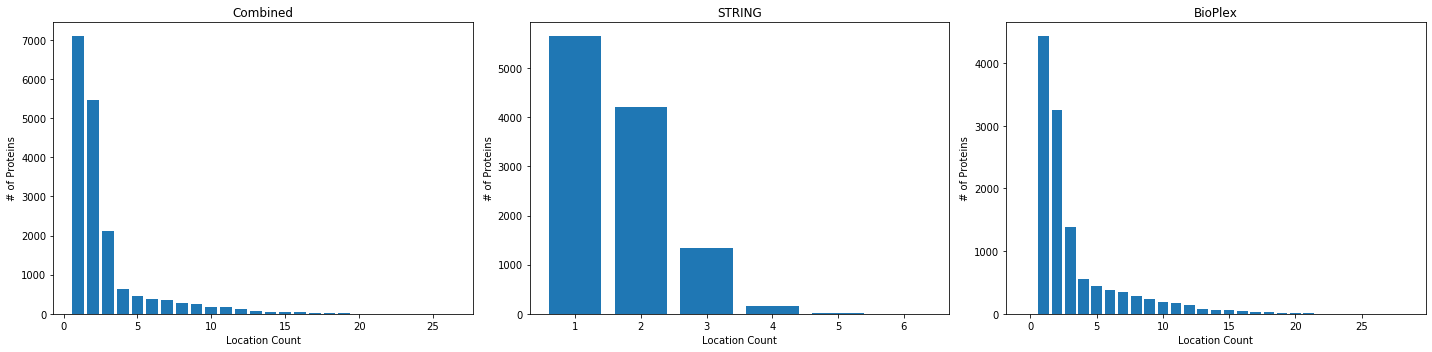

In [6]:
retain_vals = [1]      #List of values for which plots are to be created

flag = True                                    # Optimizing generation loc2id mappings
i = 0

# For each info_retain value, create a bar plot for complete data, STRING, and BioPlex.
for val in retain_vals:
    
    loc_a = get_loc_values(df_all, info_retain=val)
    loc_s = get_loc_values(df_string, info_retain=val)
    loc_b = get_loc_values(df_bioplex, info_retain=val)

    # if flag:
    #     locs = loc_a.keys()
    #     loc2id = {k: v for v,k in enumerate(locs)}
    #     flag = False
    
    loc_a = {k: v for k,v in loc_a.items()}
    loc_s = {k: v for k,v in loc_s.items()}
    loc_b = {k: v for k,v in loc_b.items()}

    plot(
        loc_a, 
        loc_s, 
        loc_b, 
        f'../info_plots/InfoRetainLocs2_{100*retain_vals[i]}.png'
    )
    i += 1